Import configs

In [1]:
# Core neuromaps modules
from neuromaps.datasets import fetch_annotation, fetch_atlas
from neuromaps.transforms import (
    fsaverage_to_fslr,
    fslr_to_fslr,
    civet_to_fslr,
)
from neuromaps.images import load_data, load_gifti
from neuromaps.stats import compare_images  # optional, for later correlations
from neuromaps.parcellate import Parcellater  # optional, for future analyses
from neuromaps import transforms  # optional, for direct access to transform functions

# Standard libraries
import os
from pathlib import Path

# Numeric and plotting
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib.image as mpimg

# correlation and spin-test
import pandas as pd
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from statsmodels.stats.multitest import multipletests

# other data shuffling methods
from neuromaps.nulls import vazquez_rodriguez

import os

# Add Connectome Workbench to PATH for neuromaps
os.environ["PATH"] = "/Applications/Workbench/bin_macosxub:" + os.environ["PATH"]

# Test that wb_command is now visible
import subprocess
subprocess.run(["wb_command", "-version"])


Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


CompletedProcess(args=['wb_command', '-version'], returncode=0)

## Background

In the neuromaps paper, when comparing a source map (e.g., the schizophrenia map in MNI152) to multiple target maps, they always transformed the source map into the coordinate system of the target map.

However, for our source map (hcps1200 thickness fsLR 32k) and most target maps are already in surface spaces (fsLR, fsaverage, CIVET), and sometimes even the same one. So, we just apply that same rule logically but adapt it based on resolution.

Rules:
- If target and source share the same space and density → no transformation.
- If they share the same space but different densities → transform the higher-resolution dataset to the lower-resolution one.
- If they are in different spaces (fsaverage, CIVET, MNI152) → transform the target map to the source’s space (fsLR 32k).
This keeps everything aligned to a single reference grid for correlation

Assessing the impact of coordinate system
When transforming two datasets (that is, a source and target dataset) defined in distinct coordinate spaces to a common system there are at least three options available: transform the source dataset to the system of the target, transform the target dataset to the system of the source, or transform both source and target datasets to an alternate system. If comparisons are being made across several pairs of datasets a fourth option becomes available: always transform the higher resolution dataset to the system of the lower-resolution dataset.

## Source Map

In [2]:
src_thick = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
ref_space = ("fsLR", "32k")
src_thick_L, src_thick_R = src_thick
src_thick


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


['/Users/paigepagaduan/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-L_feature.func.gii',
 '/Users/paigepagaduan/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-R_feature.func.gii']

## Target Maps

| #      | Category                                               | Source          | Description                | Space     | Density |
| ------ | ------------------------------------------------------ | --------------- | -------------------------- | --------- | ------- |
| **1**  | PC1 Gene Expression                                         | `abagen`        | `genepc1`                  | fsaverage | 10k     |
| **2**  | T1w/T2w Ratio                            | `hcps1200`      | `myelinmap`                | fsLR      | 32k     |
| **3**  | Developmental Expansion                                | `hill2010`      | `devexp`                   | fsLR      | 164k    |
| **4**  | Evolutionary Expansion              | `hill2010`      | `evoexp`   | fsLR      | 164k     |
| **5**  | Functional Gradient                             | `margulies2016` | `fcgradient01`  | fsLR      | 32k     |
| **6**  | Intersubject Variability                               | `mueller2013`   | `intersubjvar` | fsLR      | 164k     |
| **7**  | Cerebral Blood Flow                             | `raichle`       | `cbf`                      | fsLR      | 164k    |
| **8**  | Cerebral Blood Volume                           | `raichle`       | `cbv`                      | fsLR      | 164k    |
| **9** | Oxygen Metabolism                              | `raichle`       | `cmr02`                    | fsLR      | 164k    |
| **10** | Glucose Metabolism                            | `raichle`       | `cmrglc`                   | fsLR      | 164k    |
| **11** | Allometric Scaling (NIH) (Developmental Expansion Proxy) | `reardon2018`   | `scalingnih`               | CIVET     | 41k     |
| **12** | Allometric Scaling (PNC)                                | `reardon2018`   | `scalingpnc`               | CIVET     | 41k     |


## Transformations

In [3]:
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import numpy as np
from nilearn.plotting import plot_surf
from neuromaps.datasets import ALIAS, fetch_atlas
from neuromaps.images import load_gifti
from neuromaps.transforms import _check_hemi

HEMI = dict(L='left', R='right')

def plot_surf_lateral_only(
    data, template, density, *,
    surf='inflated', hemi=None, mask_medial=True,
    colorbar='shared',          # 'none', 'each', or 'shared'
    cbar_location='right',      # 'right' or 'bottom' when colorbar='shared'
    vmin=None, vmax=None,       # shared limits. If None they are computed
    wspace=0.12, figsize=(10, 4), **kwargs
):
    """
    Lateral-only surface plot with optional shared colorbar.
    Returns (fig, cbar) where cbar can be None.
    """
    atlas = fetch_atlas(template, density, verbose=0)
    template = ALIAS.get(template, template)
    if template == 'MNI152':
        raise ValueError("Cannot plot MNI152 on the surface. Project to a surface first.")

    surf_geom = atlas[surf]
    medial = atlas['medial']

    # nilearn defaults
    opts = dict(alpha=1.0, threshold=np.spacing(1))
    opts.update(**kwargs)
    if kwargs.get('bg_map') is not None and kwargs.get('alpha') is None:
        opts['alpha'] = 'auto'

    data, hemispheres = zip(*_check_hemi(data, hemi))
    n_hemi = len(data)

    # collect data arrays to compute shared limits if needed
    arrays = []
    for img in data:
        arr = load_gifti(img).agg_data().astype('float32')
        if mask_medial:
            # we do not know hemisphere here yet, compute after
            arrays.append(arr)
        else:
            arrays.append(arr)

    if vmin is None or vmax is None:
        # robust range across hemispheres
        allvals = np.concatenate([np.ravel(a[np.isfinite(a)]) for a in arrays])
        vmin = np.nanmin(allvals) if vmin is None else vmin
        vmax = np.nanmax(allvals) if vmax is None else vmax
    opts.update(dict(vmin=vmin, vmax=vmax))

    fig, axes = plt.subplots(1, n_hemi, subplot_kw={'projection': '3d'}, figsize=figsize)
    axes = (axes,) if n_hemi == 1 else axes

    # if we will add a shared colorbar, turn per-panel colorbars off
    per_panel_cbar = (colorbar == 'each')
    if colorbar == 'shared':
        opts['colorbar'] = False
    else:
        opts['colorbar'] = per_panel_cbar

    for ax, h, img in zip(axes, hemispheres, data):
        geom = load_gifti(getattr(surf_geom, h)).agg_data()
        arr = load_gifti(img).agg_data().astype('float32')
        if mask_medial:
            med = load_gifti(getattr(medial, h)).agg_data().astype(bool)
            arr[~med] = np.nan

        ax.disable_mouse_rotation()
        plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)

    # spacing between hemispheres
    fig.subplots_adjust(wspace=wspace)

    # optional shared colorbar
    cbar = None
    if colorbar == 'shared':
        sm = ScalarMappable(norm=mcolors.Normalize(vmin=vmin, vmax=vmax),
                            cmap=opts.get('cmap', None))
        sm.set_array([])
        if cbar_location == 'right':
            cbar = fig.colorbar(sm, ax=axes, location='right', fraction=0.05, pad=0.03)
        else:  # bottom
            cbar = fig.colorbar(sm, ax=axes, location='bottom', fraction=0.05, pad=0.3)

    return fig, cbar


### PC1 gene expression

In [4]:
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
genepc1_fsLR32k = fsaverage_to_fslr(genepc1, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'PC1 fsLR 32k')

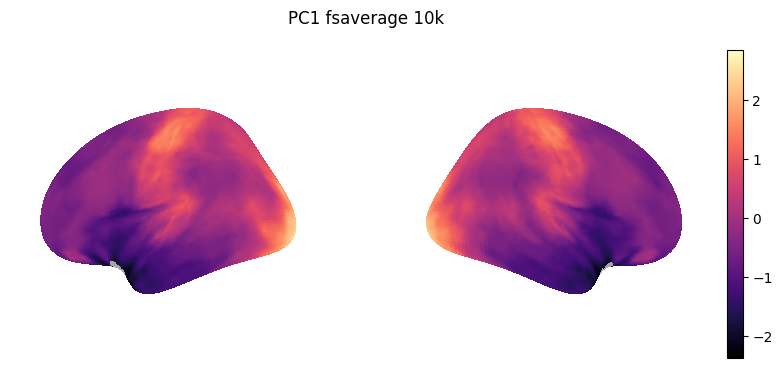

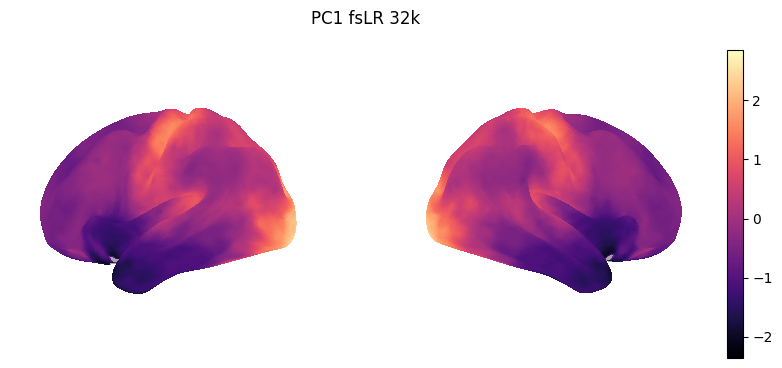

In [5]:
fig1, cbar1 = plot_surf_lateral_only(
    genepc1, template='fsaverage', density='10k',
    cmap='magma', colorbar='shared', cbar_location='right', wspace=0.18
)
fig1.suptitle('PC1 fsaverage 10k', y=0.98)

fig2, cbar2 = plot_surf_lateral_only(
    genepc1_fsLR32k, template='fsLR', density='32k',
    cmap='magma', colorbar='shared', cbar_location='right', wspace=0.18
)
fig2.suptitle('PC1 fsLR 32k', y=0.98)


This map shows the **first principal component (PC1)** of **cortical gene expression** projected onto the **fsLR 32k surface**, capturing the main spatial pattern of molecular variation across the cortex.

**PC1 of gene expression** summarizes how genes vary together spatially, regions with similar expression patterns load similarly on this component. It often reflects a **molecular gradient** from **sensory–motor areas** to **association cortices**, linking underlying biology to cortical specialization.

In this map, **warm colors (yellow/orange)** represent **higher PC1 loadings**, indicating regions with stronger expression of genes contributing positively to this component, while **cool colors (purple)** show **lower loadings** or opposing expression patterns.


### T1w/T2w ratio

In [6]:
myelinmap = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
myelinmap_fsLR32k = myelinmap  # already in target space


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'T1w/T2w ratio fsLR 32k')

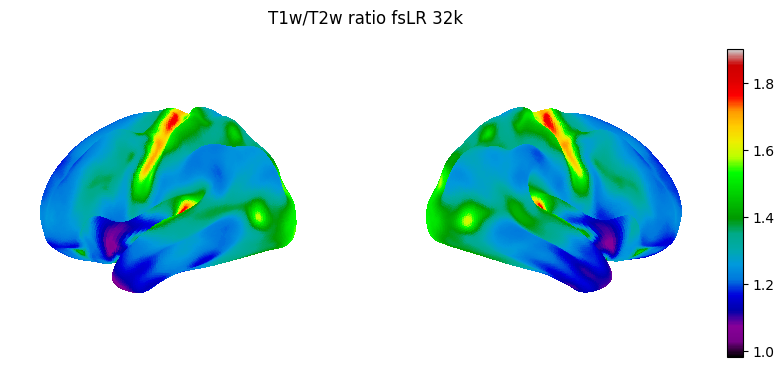

In [7]:
fig3, cbar3 = plot_surf_lateral_only(
    myelinmap_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.98, vmax=1.9
)
fig3.suptitle('T1w/T2w ratio fsLR 32k', y=0.98)

This map shows the **T1w/T2w ratio** projected onto the **fsLR 32k surface**, which serves as an MRI-based measure of **cortical myelination**.

**Myelination** is the process of coating nerve fibers with a fatty layer called **myelin**, allowing electrical signals to travel faster and more efficiently between brain regions.

In the map, **warm colors (red/yellow)** indicate areas with **higher T1w/T2w ratios**, meaning greater myelin content, typically in **primary sensory and motor regions**. **Cool colors (blue/green)** represent **lower ratios**, found in **association and prefrontal cortices**. This reflects the brain’s **myelin gradient**, from fast, highly myelinated areas to slower, integrative regions involved in complex cognition.


### Developmental expansion



In [8]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
print(type(devexp), devexp)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
<class 'str'> /Users/paigepagaduan/neuromaps-data/annotations/hill2010/devexp/fsLR/source-hill2010_desc-devexp_space-fsLR_den-164k_hemi-R_feature.func.gii


Because hill2010/devexp only exists for the right hemisphere we transformed it like this:

In [9]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
devexp_fsLR = fslr_to_fslr(devexp, '32k', hemi='R')
devexp_rh_32k, = devexp_fsLR

# Check data shape
print(devexp_rh_32k.agg_data().shape)
devexp_fsLR


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
(32492,)


(<nibabel.gifti.gifti.GiftiImage at 0x108be76d0>,)

/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Developmental expansion fsLR 32k')

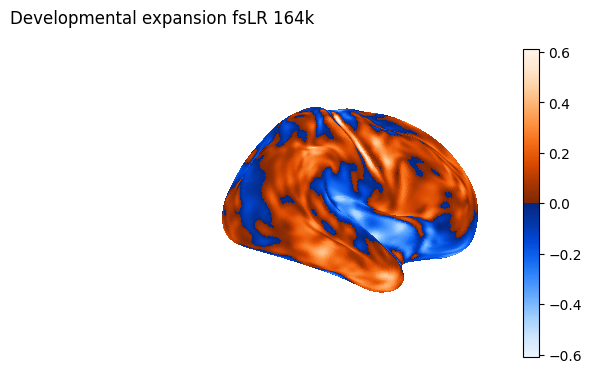

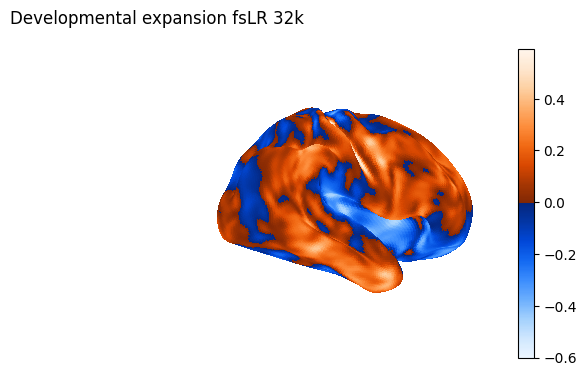

In [10]:
fig4, cbar4 = plot_surf_lateral_only(
    devexp, template='fsLR', density='164k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-0.61, vmax=0.61
)
fig4.suptitle('Developmental expansion fsLR 164k', y=0.98)

fig5, cbar5 = plot_surf_lateral_only(
    devexp_fsLR, template='fsLR', density='32k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-0.6, vmax=0.59
)
fig5.suptitle('Developmental expansion fsLR 32k', y=0.98)

This map shows **developmental expansion** projected onto the **fsLR 32k cortical surface**, illustrating how much each brain region expands during development.

**Developmental expansion** refers to how certain cortical areas grow more in surface area or volume as the brain matures. Regions that expand more are often linked to **higher cognitive functions**, like planning and reasoning, while less expanding regions are associated with **basic sensory and motor processing**.

In this map, **warm colors (orange/red)** mark **greater expansion**, mainly in association cortices, and **cool colors (blue)** show **less expansion**, typically in primary sensory and motor areas. This pattern reflects how the brain develops from early-maturing sensorimotor regions to later-developing association regions involved in complex thought.


### Evolutionary expansion



In [11]:
evoexp = fetch_annotation(source='hill2010', desc='evoexp', space='fsLR', den='164k', hemi='R')
evoexp_fsLR32k = fslr_to_fslr(evoexp, target_density='32k', hemi='R')
evoexp_rh_32k, = evoexp_fsLR32k

# Check data shape
print(evoexp_rh_32k.agg_data().shape)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
(32492,)


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Evolutionary expansion fsLR 32k')

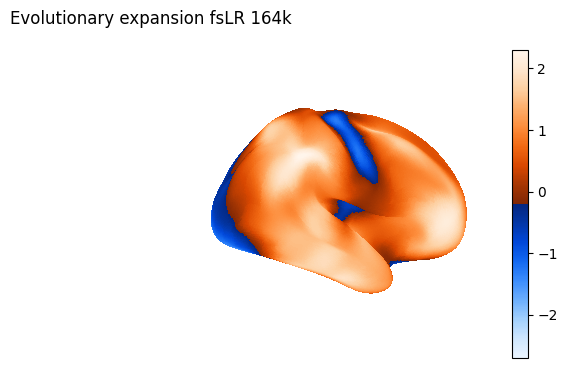

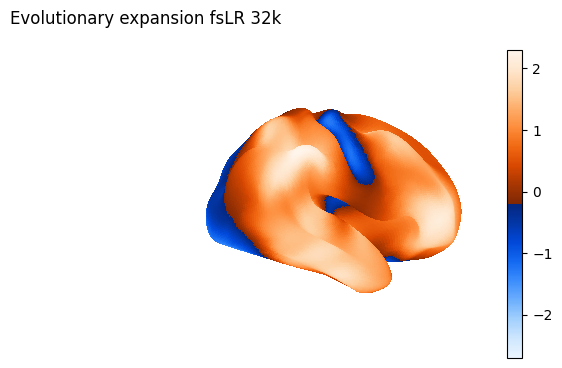

In [12]:
fig6, cbar6 = plot_surf_lateral_only(
    evoexp, template='fsLR', density='164k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-2.7, vmax=2.3
)
fig6.suptitle('Evolutionary expansion fsLR 164k', y=0.98)

fig7, cbar7 = plot_surf_lateral_only(
    evoexp_fsLR32k, template='fsLR', density='32k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-2.7, vmax=2.3
)
fig7.suptitle('Evolutionary expansion fsLR 32k', y=0.98)

This map shows **evolutionary expansion** projected onto the **fsLR 32k cortical surface**, representing how much different cortical regions have expanded over the course of primate evolution.

**Evolutionary expansion** compares the size of cortical areas in humans to those in non-human primates. Regions that have expanded the most are associated with **higher-order cognition**, language, and abstract reasoning, while less expanded regions are tied to **sensory and motor processing** shared across species.

In this map, **warm colors (orange/red)** indicate **greater evolutionary expansion**, mainly in association cortices such as the prefrontal and temporal areas. **Cool colors (blue)** show **less expansion**, seen in early-developing sensory and motor regions. This pattern reflects how evolution has prioritized the growth of brain areas involved in complex thought and social behavior.


### Functional gradient



In [13]:
gradient_pc1 = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
gradient_pc1_fsLR32k = gradient_pc1


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Functional gradient fsLR 32k')

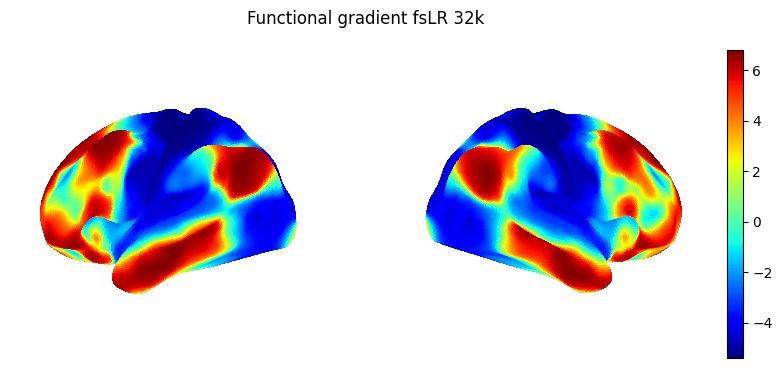

In [14]:
fig8, cbar8 = plot_surf_lateral_only(
    gradient_pc1_fsLR32k, template='fsLR', density='32k',
    cmap='jet', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-5.4, vmax=6.8
)
fig8.suptitle('Functional gradient fsLR 32k', y=0.98)

This map shows the **functional gradient** projected onto the **fsLR 32k cortical surface**, capturing large-scale organization of brain activity.

A **functional gradient** describes how patterns of connectivity transition smoothly across the cortex, from regions involved in **basic sensory and motor processing** to those supporting **higher-order, integrative cognition**.

In this map, **warm colors (red/yellow)** represent areas at the **higher end of the gradient**, such as the default mode and association networks that integrate abstract information. **Cool colors (blue)** mark regions at the **lower end**, corresponding to primary sensory and motor areas with more specialized, unimodal processing. This gradient reflects the brain’s shift from concrete perception to complex thought.


### Intersubject variability



In [15]:
isv = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
isv_fsLR32k = fslr_to_fslr(isv, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Intersubject variability fsLR 32k')

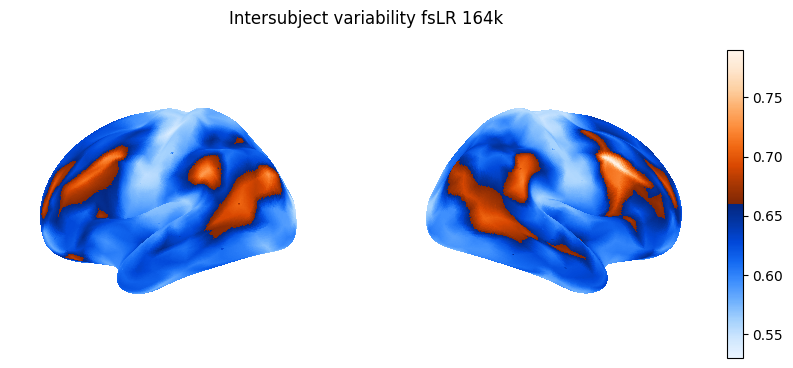

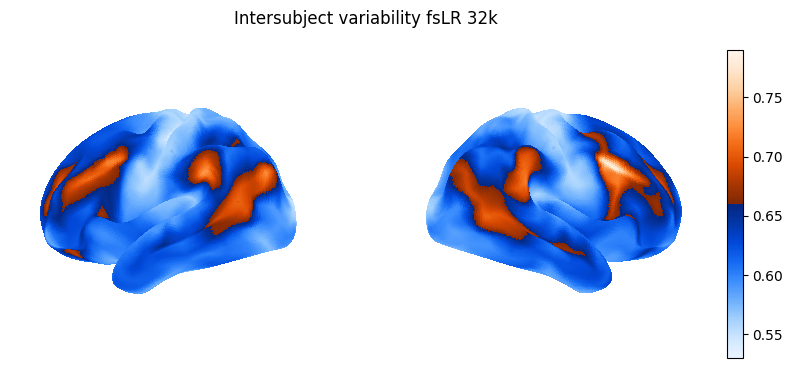

In [16]:
fig9, cbar9 = plot_surf_lateral_only(
    isv, template='fsLR', density='164k',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.53, vmax=0.79
)
fig9.suptitle('Intersubject variability fsLR 164k', y=0.98)

fig10, cbar11 = plot_surf_lateral_only(
    isv_fsLR32k, template='fsLR', density='32k',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.53, vmax=0.79
)
fig10.suptitle('Intersubject variability fsLR 32k', y=0.98)

This map shows **intersubject variability** on the **fsLR 32k cortical surface**, indicating how much brain organization differs across individuals.

**Intersubject variability** measures how consistent or diverse functional patterns are between people. Regions with **low variability** are highly similar across individuals, while **high variability** regions show greater differences in connectivity or function.

In this map, **warm colors (orange)** represent **higher variability**, typically in association cortices like the prefrontal and temporal regions involved in complex cognition and social processing. **Cool colors (blue)** indicate **lower variability**, found in sensory and motor areas that are more structurally and functionally conserved across people.


### Cerebral blood flow



In [17]:
cbf = fetch_annotation(source='raichle', desc='cbf', space='fsLR', den='164k')
cbf_fsLR32k = fslr_to_fslr(cbf, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbf', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Cerebral blood flow fsLR 32k')

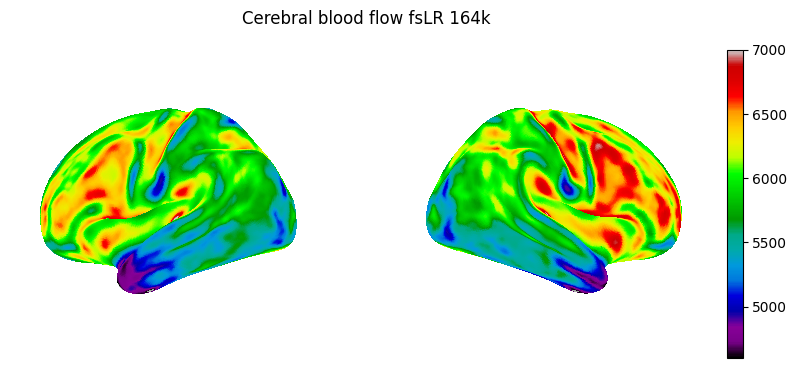

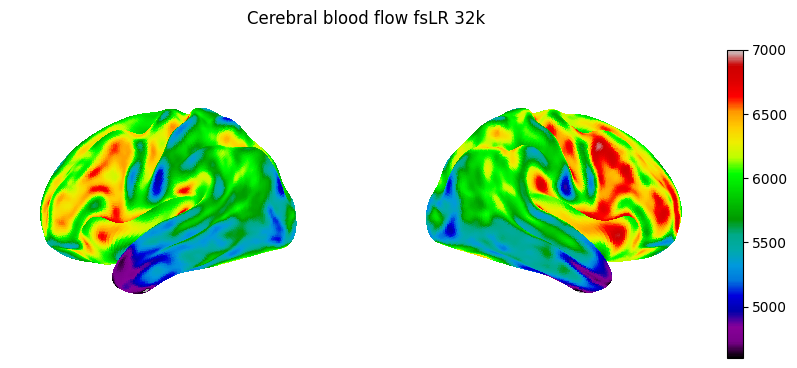

In [18]:
fig11, cbar11 = plot_surf_lateral_only(
    cbf, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4600, vmax=7000
)
fig11.suptitle('Cerebral blood flow fsLR 164k', y=0.98)

fig12, cbar12 = plot_surf_lateral_only(
    cbf_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4600, vmax=7000
)
fig12.suptitle('Cerebral blood flow fsLR 32k', y=0.98)

This map shows **cerebral blood flow (CBF)** projected onto the **fsLR 32k cortical surface**, representing how much blood is delivered to different regions of the brain.

**Cerebral blood flow** reflects local **metabolic and neural activity**, since active brain areas require more oxygen and nutrients. Regions with **higher CBF** are more metabolically active, while **lower CBF** indicates reduced activity or energy demand.

In this map, **warm colors (red/yellow)** show **higher blood flow**, typically in association areas that support complex cognitive processes. **Cool colors (green/blue)** indicate **lower blood flow**, often in sensory and motor regions with more stable baseline activity.


### Cerebral blood volume



In [19]:
cbv = fetch_annotation(source='raichle', desc='cbv', space='fsLR', den='164k')
cbv_fsLR32k = fslr_to_fslr(cbv, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbv', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Cerebral blood volume fsLR 32k')

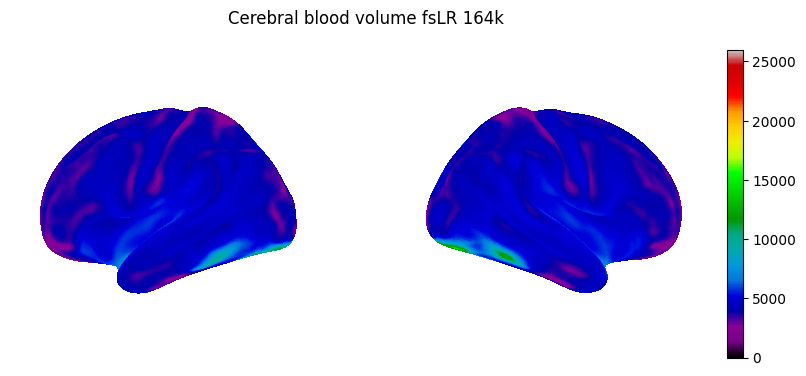

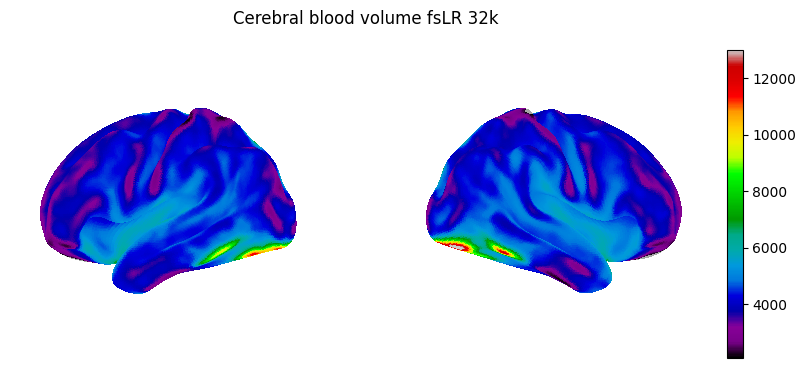

In [20]:
fig13, cbar13 = plot_surf_lateral_only(
    cbv, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=26000
)
fig13.suptitle('Cerebral blood volume fsLR 164k', y=0.98)

fig14, cbar14 = plot_surf_lateral_only(
    cbv_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=2100, vmax=13000
)
fig14.suptitle('Cerebral blood volume fsLR 32k', y=0.98)

This map shows **cerebral blood volume (CBV)** projected onto the **fsLR 32k cortical surface**, illustrating how much blood is contained within brain tissue at a given time.

**Cerebral blood volume** reflects the **amount of vascularization** in each region, closely tied to metabolic demands and neural activity. Areas with higher CBV have denser blood vessel networks that support greater energy needs.

In this map, **warm colors (red/yellow)** represent **higher CBV**, indicating regions with rich vascular supply, while **cool colors (blue/purple)** show **lower CBV**, corresponding to areas with less blood volume or lower baseline metabolism.


### Oxygen metabolism



In [21]:
cmro2 = fetch_annotation(source='raichle', desc='cmr02', space='fsLR', den='164k')
cmro2_fsLR32k = fslr_to_fslr(cmro2, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmr02', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Oxygen metabolism fsLR 32k')

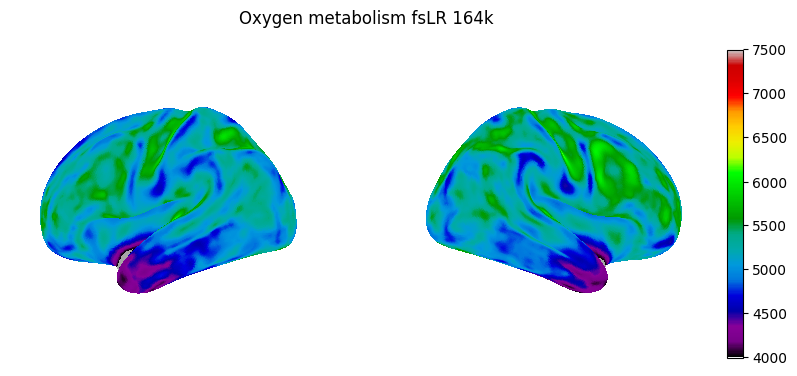

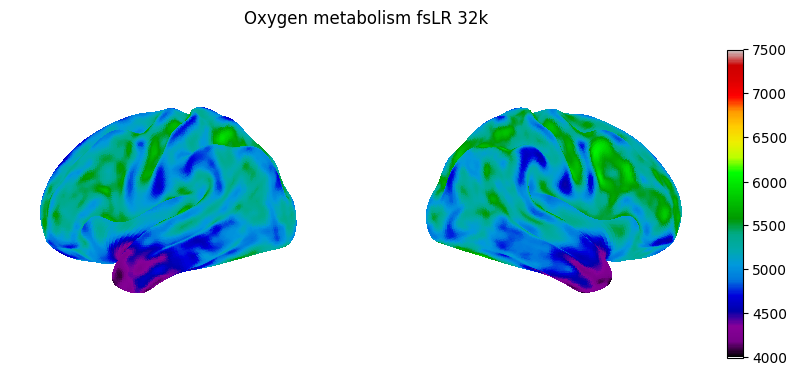

In [22]:
fig15, cbar15 = plot_surf_lateral_only(
    cmro2, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4000, vmax=7500
)
fig15.suptitle('Oxygen metabolism fsLR 164k', y=0.98)

fig16, cbar16 = plot_surf_lateral_only(
    cmro2_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4000, vmax=7500
)
fig16.suptitle('Oxygen metabolism fsLR 32k', y=0.98)

This map shows **oxygen metabolism** projected onto the **fsLR 32k cortical surface**, reflecting how much oxygen different regions of the brain consume.

**Oxygen metabolism** measures the brain’s **energy use**, since active neurons require oxygen to produce ATP, the cell’s energy source. Regions with higher oxygen metabolism are more energetically demanding and typically support complex processing.

In this map, **warm colors (red/yellow)** represent **higher oxygen consumption**, indicating regions with greater metabolic activity. **Cool colors (blue/purple)** show **lower oxygen metabolism**, found in areas with reduced baseline energy use or simpler functional roles.


### Glucose metabolism



In [23]:
cmrglc = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR', den='164k')
cmrglc_fsLR32k = fslr_to_fslr(cmrglc, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Glucose metabolism fsLR 32k')

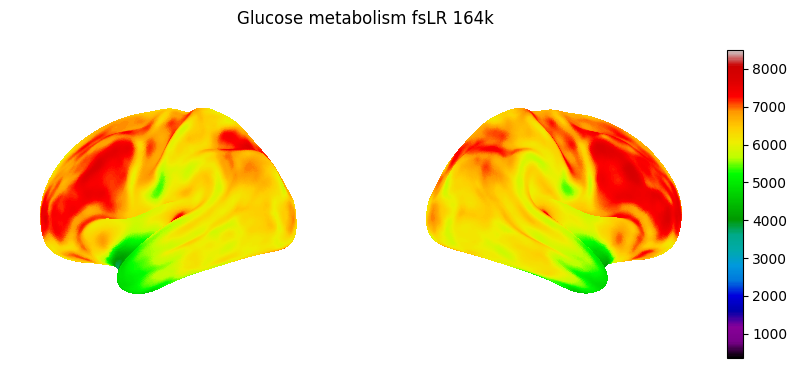

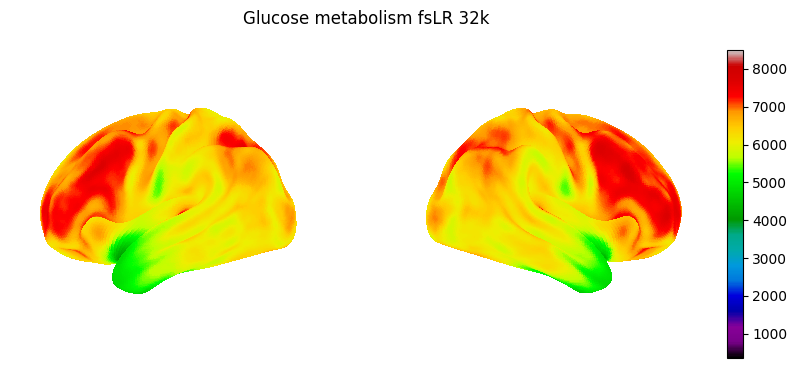

In [24]:
fig17, cbar17 = plot_surf_lateral_only(
    cmrglc, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=360, vmax=8500
)
fig17.suptitle('Glucose metabolism fsLR 164k', y=0.98)

fig18, cbar18 = plot_surf_lateral_only(
    cmrglc_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=360, vmax=8500
)
fig18.suptitle('Glucose metabolism fsLR 32k', y=0.98)

This map shows **glucose metabolism** projected onto the **fsLR 32k cortical surface**, indicating how much glucose different brain regions use as an energy source.

**Glucose metabolism** reflects the brain’s **energy consumption**, since glucose is its main fuel for supporting neural activity. Areas that engage in complex processing or have dense synaptic activity require more glucose to sustain function.

In this map, **warm colors (red/yellow)** represent **higher glucose metabolism**, typically in association cortices that support cognition and integration of information. **Cool colors (green/blue)** show **lower glucose use**, found in sensory and motor areas with lower baseline energy demands.


### Allometric scaling (NIH)



In [25]:
scalingnih = fetch_annotation(source='reardon2018', desc='scalingnih', space='civet', den='41k')
scalingnih_fsLR32k = civet_to_fslr(scalingnih, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Allometric scaling (NIH) fsLR 32k')

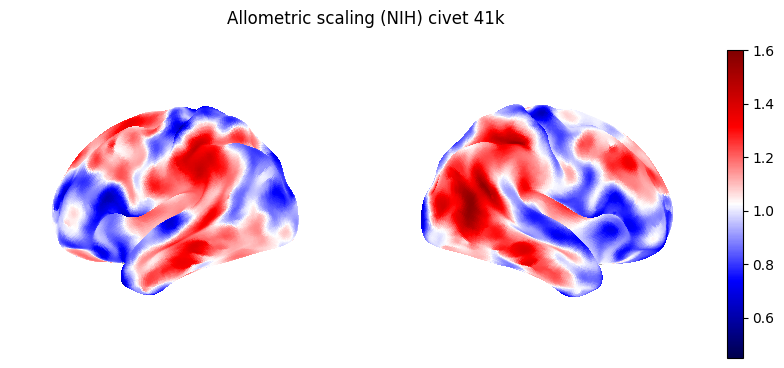

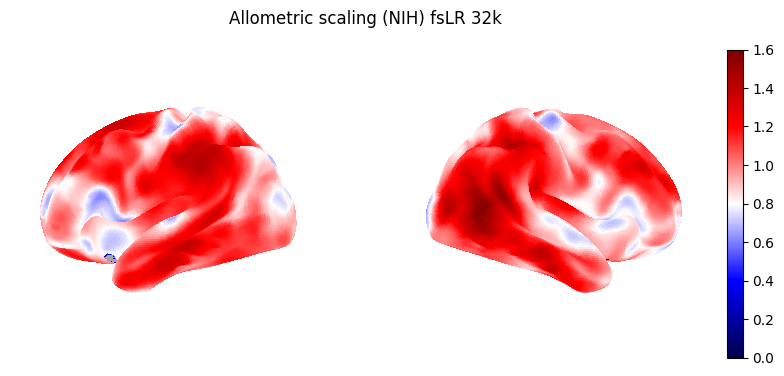

In [26]:
fig19, cbar19 = plot_surf_lateral_only(
    scalingnih, template='civet', density='41k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.45, vmax=1.6
)
fig19.suptitle('Allometric scaling (NIH) civet 41k', y=0.98)

fig20, cbar20 = plot_surf_lateral_only(
    scalingnih_fsLR32k, template='fsLR', density='32k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=1.6
)
fig20.suptitle('Allometric scaling (NIH) fsLR 32k', y=0.98)

This map shows **allometric scaling (NIH)** projected onto the **fsLR 32k cortical surface**, representing how different brain regions scale in size relative to overall brain growth.

**Allometric scaling** describes how the size or structure of a region changes as total brain size increases. Regions with higher scaling values grow disproportionately larger in bigger brains, suggesting increased investment in certain functions like association and integrative processing.

In this map, **warm colors (red)** indicate **greater allometric scaling**, meaning those areas expand more rapidly relative to brain size, typically in higher-order cortical regions. **Cool colors (blue)** mark **lower scaling**, seen in early-developing sensory and motor areas that scale more proportionally.


### Allometric scaling (PNC)



In [27]:
scalingpnc = fetch_annotation(source='reardon2018', desc='scalingpnc', space='civet', den='41k')
scalingpnc_fsLR32k = civet_to_fslr(scalingpnc, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingpnc', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_33336/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Allometric scaling (PNC) fsLR 32k')

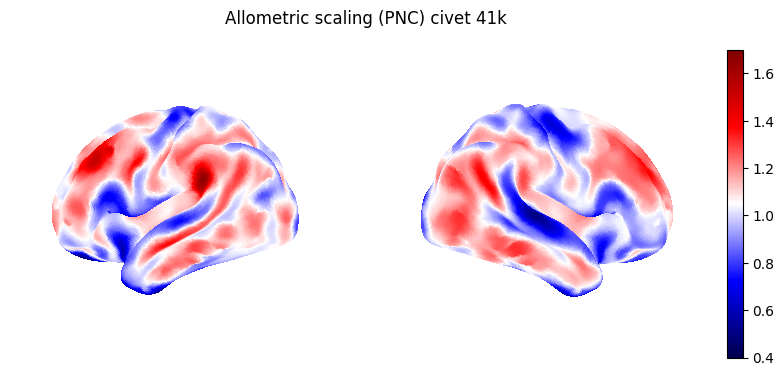

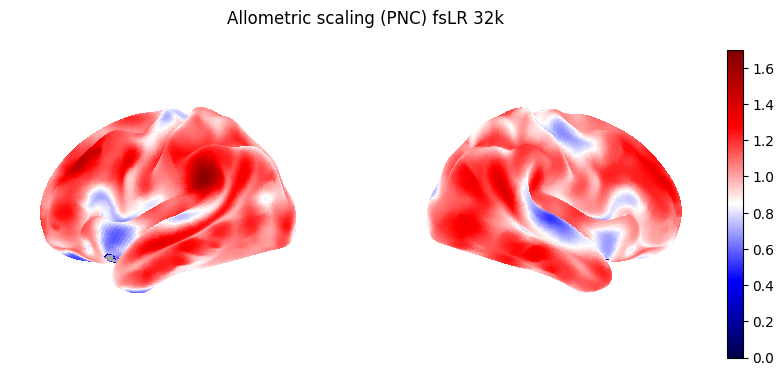

In [28]:
fig21, cbar21 = plot_surf_lateral_only(
    scalingpnc, template='civet', density='41k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.4, vmax=1.7
)
fig21.suptitle('Allometric scaling (PNC) civet 41k', y=0.98)

fig22, cbar22 = plot_surf_lateral_only(
    scalingpnc_fsLR32k, template='fsLR', density='32k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=1.7
)
fig22.suptitle('Allometric scaling (PNC) fsLR 32k', y=0.98)

This map shows **allometric scaling (PNC)** projected onto the **civet 41k cortical surface**, illustrating how regional brain size changes relative to overall brain size in the **Philadelphia Neurodevelopmental Cohort (PNC)** dataset.

**Allometric scaling** measures how certain regions expand or contract disproportionately as total brain size varies across individuals. Regions that scale up more strongly are thought to support **higher cognitive or integrative functions**, while regions that scale proportionally relate to **basic sensory or motor processing**.

In this map, **warm colors (red)** indicate **greater scaling**, meaning those areas expand faster with brain size, often in association cortices. **Cool colors (blue)** represent **lower scaling**, where growth is more proportional, typically in early-developing sensory regions.


## Aggregate Plots

In [29]:
# main_dir = os.getcwd()
# folder_path = "../neuromaps-schizophrenia-thinning/figures"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# os.chdir(folder_path)

# # Save your individual figures
# for i, fig in enumerate([fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10,
#         fig11, fig12, fig13, fig14, fig15, fig16, fig17, fig18, fig19,
#         fig20, fig21, fig22], start=1):
#     fig.savefig(f'fig{i}.png', dpi=150, bbox_inches='tight')

# # Combine into two columns
# fig, axes = plt.subplots(11, 2, figsize=(10, 48))  # 23 → 12 rows x 2 cols
# axes = axes.flatten()

# for i in range(22):
#     img = mpimg.imread(f'fig{i+1}.png')
#     axes[i].imshow(img)
#     axes[i].axis('off')

# # Hide any empty subplot
# for j in range(22, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# fig.savefig("combined_figures.png", dpi=150, bbox_inches="tight")

# plt.show()

# os.chdir("..")

## Correlations & Spin Test

#### Correlations

After transforming all target maps into the same cortical surface space (fsLR-32k), the next step is to quantify how strongly each target map’s spatial pattern aligns with the average cortical thickness pattern from the Human Connectome Project (HCP S1200 dataset).

We measure this alignment using Pearson’s correlation coefficient (r) across corresponding cortical vertices.

This tells us whether regions that are thicker or thinner in the healthy human cortex also tend to show higher or lower values in each biological or functional brain feature (e.g., myelination, metabolism, or gene expression):
- r > 0 → Regions that are thicker tend to have higher values in the target map. Example: a positive r with developmental expansion would indicate that thicker cortex corresponds to regions that expanded more during development.
- r < 0 → Regions that are thicker tend to have lower values in the target map.
For instance, a negative r with myelin means thicker cortex is found in less-myelinated areas.
- r ≈ 0 → No clear spatial relationship between cortical thickness and the target feature.

#### Spin Test

Brain maps aren’t random: neighboring vertices tend to have similar values.

What it does:
- It generates thousands of rotated versions (“spins”) of the source cortical map on the sphere.
- Each spin keeps the map’s smooth, spatially autocorrelated structure but moves its pattern to new cortical locations.
- For each rotated map, you recompute the correlation with the target.

You get a null distribution of correlations that would occur purely by chance under the same spatial smoothness. The empirical correlation is then compared to this null distribution to compute a spin p-value (Pspin). A small Pspin (e.g., 0.001) means your observed alignment is stronger than what 999 of 1000 random spatial rotations produce → statistically significant after accounting for spatial autocorrelation.


In [30]:
# HELPER FUNCTIONS

def data1d(x):
    """Path or GiftiImage -> 1D array."""
    img = x if isinstance(x, nib.gifti.gifti.GiftiImage) else nib.load(x)
    return np.asarray(img.agg_data()).squeeze()

def lr_arrays(entry, nL=32492, nR=32492, fill='nan', L_mean=None):
    """
    Normalize an entry into (L, R) arrays.
    - entry can be (L, R) objects or paths
    - or a single-hemi object/path (we detect by user input; pass None for missing)
    - fill strategy controls what to do if only one hemisphere is provided:
        'nan'    → pad missing hemi with NaNs
        'mirror' → copy the existing hemi to both sides
        'mean'   → fill missing hemi with provided L_mean array
    """
    # Case 1: both hemispheres provided
    if isinstance(entry, (tuple, list)) and len(entry) == 2:
        L, R = entry
        L_arr = data1d(L) if L is not None else np.full(nL, np.nan)
        R_arr = data1d(R) if R is not None else np.full(nR, np.nan)
        return L_arr, R_arr

    # Case 2: single hemisphere only
    arr = data1d(entry)

    if fill == 'mirror':
        # Duplicate the same array for both hemispheres
        return arr.copy(), arr.copy()

    else:  # default = NaN padding
        return np.full(nL, np.nan), arr


In [31]:
# LIST OF MAPS

maps = {
    "source_thickness": src_thick,         # list of paths [L_path, R_path]
    "genepc1":           genepc1_fsLR32k,
    "myelin":            myelinmap_fsLR32k,
    "devexp":            (None, devexp_rh_32k),
    "evoexp":            (None, evoexp_rh_32k),
    "gradient_pc1":      gradient_pc1_fsLR32k,
    "isv":               isv_fsLR32k,
    "cbf":               cbf_fsLR32k,
    "cbv":               cbv_fsLR32k,
    "cmro2":             cmro2_fsLR32k,
    "cmrglc":            cmrglc_fsLR32k,
    "scalingnih":        scalingnih_fsLR32k,
    "scalingpnc":        scalingpnc_fsLR32k,
}

In [32]:
N_PERM = 1000
SEED = 42

# Load all L/R arrays per map into hemisphere-wise dicts
arrays_L, arrays_R = {}, {}
for name, entry in maps.items():
    L_arr, R_arr = lr_arrays(entry)
    arrays_L[name], arrays_R[name] = L_arr, R_arr

# Make whole-cortex vectors by concatenating L and R
vectors = {name: np.concatenate([arrays_L[name], arrays_R[name]]) for name in arrays_L}

# Get the source map
src_name = "source_thickness"
src_vec = vectors[src_name]


# Generate spin-based nulls on the source map
nulls = alexander_bloch(
    data=src_thick,     # data to spin
    atlas='fsLR',       # which atlas space we're spinning on
    density='32k',      # resolution
    n_perm=N_PERM,      # number of rotations
    seed=SEED           # reproducibility
)

# Check if rows (= vertices) of nulls must match length of src_vec
assert nulls.shape[0] == src_vec.size, f"nulls rows = {nulls.shape[0]}, expected {src_vec.size}" # 64984
assert nulls.shape[1] == N_PERM, f"nulls columns = {nulls.shape[1]}, expected {N_PERM}" # 1000


In [33]:
# --- main loop ---
rows = []

for name, tgt_vec in vectors.items():
    if name == src_name:
        continue

    # observed correlation
    r_obs = compare_images(src_vec, tgt_vec, metric="pearsonr", ignore_zero=True)

    # null correlations: iterate over columns now
    r_null = np.array([
        compare_images(nulls[:, i], tgt_vec, metric="pearsonr", ignore_zero=True)
        for i in range(N_PERM)
    ])

    # two-tailed p-value
    p_spin = (np.sum(np.abs(r_null) >= np.abs(r_obs)) + 1) / (N_PERM + 1)

    rows.append({"map": name, "r": float(r_obs), "p_spin": float(p_spin)})

df = pd.DataFrame(rows).sort_values("p_spin")

## FDR Correction

Identifies which correlations are truly significant.

What it does:
- Adjusts the p-values so that, across all 12 tests, the expected proportion of false discoveries among those declared significant stays ≤ 5%.
- Uses the Benjamini–Hochberg (BH) procedure:
    1. Sort p values from smallest → largest.
    2. Compare each to its rank-scaled threshold.
    3. Mark as significant if p ≤ threshold.

In [34]:
# --- FDR correction with alpha = 0.05 (standard)---
reject, p_fdr, _, _ = multipletests(df["p_spin"].values, alpha=0.05, method="fdr_bh")
df["p_fdr"] = p_fdr
df["sig_fdr"] = reject

df.sort_values("p_fdr")

,map,r,p_spin,p_fdr,sig_fdr
0,genepc1,-0.697060,0.000999,0.005994,True
1,myelin,-0.557634,0.000999,0.005994,True
8,cmro2,-0.461402,0.002997,0.011988,True
4,gradient_pc1,0.356469,0.028971,0.083916,False
9,cmrglc,-0.397825,0.034965,0.083916,False
5,isv,0.273599,0.100899,0.182817,False
6,cbf,-0.269239,0.118881,0.182817,False
3,evoexp,0.314704,0.121878,0.182817,False
10,scalingnih,0.135482,0.321678,0.428904,False
7,cbv,-0.078511,0.579421,0.695305,False


## Interpretation of Significant Relationships

1. `genepc1` (-0.70): 
    - The negative correlation means regions with greater cortical thickness tend to have lower genepc1 values.
    - So, thicker regions (like frontal/temporal association areas) have distinct molecular expression profiles compared to thinner, early-developing sensory regions.
2. `myelin` (-0.56): 
    - The myelin map shows how much myelin (fatty insulation) different cortical regions have
    - Negative correlation → Thicker cortex = less myelinated.
3. `cmro2` (−0.46):
    - CMRO₂ = cerebral metabolic rate of oxygen consumption.
    - Negative correlation → Thicker regions have lower baseline metabolic activity.

In [35]:
rows = []
null_corrs = {}

for name, tgt_vec in vectors.items():
    if name == src_name:
        continue

    # observed correlation
    r_obs = compare_images(src_vec, tgt_vec, metric="pearsonr", ignore_zero=True)

    # spin test null dist
    r_null = np.array([
        compare_images(nulls[:, i], tgt_vec, metric="pearsonr", ignore_zero=True)
        for i in range(N_PERM)
    ])

    # save null dist for plotting boxplot later
    null_corrs[name] = r_null

    # two sided p
    p_spin = (np.sum(np.abs(r_null) >= np.abs(r_obs)) + 1) / (N_PERM + 1)

    rows.append({
        "map": name,
        "r": float(r_obs),
        "p_spin": float(p_spin),
    })

df = pd.DataFrame(rows)


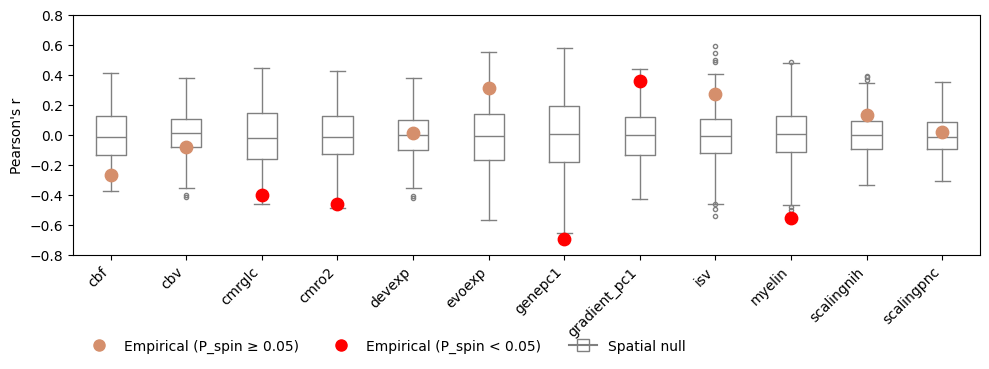

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# decide significance using p_spin or sig_fdr if you prefer FDR
alpha = 0.05
df["sig"] = df["p_spin"] < alpha

# order however you want them to appear on x axis
df = df.sort_values("map").reset_index(drop=True)

# collect null arrays in that same order
null_arrays = [null_corrs[m] for m in df["map"]]

xpos = np.arange(len(df))

fig, ax = plt.subplots(figsize=(10,4))

# draw gray boxplots for null distributions
ax.boxplot(
    null_arrays,
    positions=xpos,
    widths=0.4,
    patch_artist=False,
    boxprops=dict(color='gray', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1),
    capprops=dict(color='gray', linewidth=1),
    medianprops=dict(color='gray', linewidth=1),
    flierprops=dict(
        marker='o',
        markerfacecolor='none',
        markeredgecolor='gray',
        markersize=3,
        linestyle='none'
    ),
)

# overlay empirical r values as dots
for xi, row in df.iterrows():
    ax.scatter(
        xi,
        row["r"],
        s=80,
        color=('red' if row["sig"] else '#d58f6c'),
        zorder=3,
    )

ax.set_ylabel("Pearson's r")
ax.set_xticks(xpos)
ax.set_xticklabels(df["map"], rotation=45, ha='right')
ax.set_ylim(-0.8, 0.8)

emp_ns = mlines.Line2D([], [], color='#d58f6c', marker='o', linestyle='None', markersize=8,
                       label="Empirical (P_spin ≥ 0.05)")
emp_sig = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8,
                        label="Empirical (P_spin < 0.05)")
null_leg = mlines.Line2D([], [], color='gray', marker='s', fillstyle='none', linestyle='-', markersize=8,
                         label="Spatial null")

ax.legend(handles=[emp_ns, emp_sig, null_leg],
          loc='upper left',
          bbox_to_anchor=(0, -0.3),
          ncol=3,
          frameon=False)

plt.tight_layout()
fig.savefig("boxplots.png", dpi=150, bbox_inches="tight")
plt.show()


**Figure 2 | Spatial correlations between cortical thickness and canonical brain maps.**
The source map represents cortical thickness from the WU–Minn Human Connectome Project (HCP) S1200 release, which includes multimodal MRI data from approximately 1,200 young adults (ages 22–35) collected using standardized 3T scanning protocols across sites. The thickness map, defined in the fsLR 32k surface space, was compared against 12 target maps. Using the *neuromaps* toolbox, each target map was transformed to the fsLR 32k space to enable direct vertex-wise comparison.

Spatial Pearson’s *r* correlations were computed between the empirical thickness map and each transformed target map. Statistical significance was assessed with a two-sided spatial autocorrelation–preserving null model (“spin test,” *n* = 1,000 rotations). Red points denote significant correlations (*P*<sub>spin</sub> < 0.05), tan points indicate non-significant correlations (*P*<sub>spin</sub> ≥ 0.05), and gray boxplots represent null distributions. Boxes indicate the interquartile range, center lines mark medians, whiskers show non-outlier range limits, and open circles represent outliers. All *p*-values were corrected for multiple comparisons.


## Other Methods of Data Shuffling

Alexander-Blosch is only one of the numerous functions that neuromaps provides to generate null distributions to mitigate spatial autocorrelation within brain maps for brain map comparisons. We will take a closer look at two of these functions in particular: **Vasquez-Rodriguez**.

The Vazquez-Rodriguez method was developed from the Alexander-Bloch method, with the important distinction of being specifically for parcellated data.



In [99]:
# LIST OF MAPS

maps = {
    "source_thickness": src_thick,         # list of paths [L_path, R_path]
    "genepc1":           genepc1_fsLR32k,
    "myelin":            myelinmap_fsLR32k,
    "devexp":            (None, devexp_rh_32k),
    "evoexp":            (None, evoexp_rh_32k),
    "gradient_pc1":      gradient_pc1_fsLR32k,
    "isv":               isv_fsLR32k,
    "cbf":               cbf_fsLR32k,
    "cbv":               cbv_fsLR32k,
    "cmro2":             cmro2_fsLR32k,
    "cmrglc":            cmrglc_fsLR32k,
    "scalingnih":        scalingnih_fsLR32k,
    "scalingpnc":        scalingpnc_fsLR32k,
}

In [96]:
myelinmap_fsLR32k

['/Users/paigepagaduan/neuromaps-data/annotations/hcps1200/myelinmap/fsLR/source-hcps1200_desc-myelinmap_space-fsLR_den-32k_hemi-L_feature.func.gii',
 '/Users/paigepagaduan/neuromaps-data/annotations/hcps1200/myelinmap/fsLR/source-hcps1200_desc-myelinmap_space-fsLR_den-32k_hemi-R_feature.func.gii']

In [108]:
fetch_atlas('fsLR', '32k')['medial']

Surface(L=PosixPath('/Users/paigepagaduan/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_desc-nomedialwall_dparc.label.gii'), R=PosixPath('/Users/paigepagaduan/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-R_desc-nomedialwall_dparc.label.gii'))

In [119]:
from neuromaps.images import load_data
from neuromaps.parcellate import Parcellater
from collections.abc import Iterable


# ------------------------------------------------
# 1. Helper: ensure L/R arrays exist
# ------------------------------------------------
def lr_arrays(entry):
    """
    Ensures maps become (L_array, R_array)
    even if one hemisphere is missing.
    """
    if isinstance(entry, Iterable) and len(entry) == 2:
        L, R = entry
    else:
        raise ValueError(f"Entry must be a (L,R) pair, got: {entry}")

    if L is None:
        L_arr = None  # fsLR-32k vertex count per hemisphere
    else:
        L_arr = L

    if R is None:
        R_arr = None
    else:
        R_arr = R
    
    # L_arr = load_data(L_arr)
    # R_arr = load_data(R_arr)

    return L_arr, R_arr


# ------------------------------------------------
# 2. Load fsLR-32k atlas parcellation
# ------------------------------------------------
atlas = fetch_atlas('fsLR', '32k')

parc = Parcellater(
    parcellation=atlas["medial"],
    space="fsLR",
).fit()

parc_L = Parcellater(
    parcellation=atlas["medial"],
    space="fsLR",
    hemi='L'
).fit()

parc_R = Parcellater(
    parcellation=atlas["medial"],
    space="fsLR",
    hemi='R'
).fit()

# ------------------------------------------------
# 3. Parcellate all maps (already fsLR 32k)
# ------------------------------------------------
def parcellate_all_maps(maps_dict):
    """
    Input: dict of map_name → (L_path, R_path)
    Output: DataFrame containing parcellated values
    """
    parcel_outputs = {}

    for name, entry in maps_dict.items():
        print(f"→ Loading/parcellating: {name}")

        # Step A: ensure hemisphere arrays
        L_arr, R_arr = lr_arrays(entry)

        # Step C: parcellate
        if L_arr is not None and R_arr is not None:
            full_vec = (L_arr, R_arr)
            parc_values = parc.transform(full_vec, space='fsLR')
        elif L_arr is not None:
            parc_values = parc_L.transform(L_arr, space='fsLR', hemi='L')
        elif R_arr is not None:
            parc_values = parc_R.transform(R_arr, space='fsLR', hemi='R')
        else:
            raise ValueError(f"Both hemispheres missing for map {name}")

        parcel_outputs[name] = parc_values
        print(parc_values.shape)


    return parcel_outputs


# ------------------------------------------------
# 4. RUN PIPELINE
# ------------------------------------------------
parc_maps = parcellate_all_maps(maps)


→ Loading/parcellating: source_thickness
(1,)
→ Loading/parcellating: genepc1
(1,)
→ Loading/parcellating: myelin
(1,)
→ Loading/parcellating: devexp
(1,)
→ Loading/parcellating: evoexp
(1,)
→ Loading/parcellating: gradient_pc1
(1,)
→ Loading/parcellating: isv
(1,)
→ Loading/parcellating: cbf
(1,)
→ Loading/parcellating: cbv
(1,)
→ Loading/parcellating: cmro2
(1,)
→ Loading/parcellating: cmrglc
(1,)
→ Loading/parcellating: scalingnih
(1,)
→ Loading/parcellating: scalingpnc
(1,)


In [ ]:
from neuromaps.parcellate import Parcellater
from netneurotools import datasets as nntdata
from collections.abc import Iterable
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']


# ------------------------------------------------
# 1. Load fsLR-32k atlas parcellation
# ------------------------------------------------
# Provide path to your Schaefer400 fsLR-32k dlabel
atlas = {
    "medial": "/Users/paigepagaduan/neuromaps-data/atlases/Schaefer400_fslr32k.dlabel.nii"
}

# Full Parcellater
parc = Parcellater(
    parcellation=dlabel_to_gifti(schaefer),
    space="fsLR",
    resampling_target="parcellation"
).fit()

# Hemisphere-specific Parcellater (if you only have one hemi)
parc_L = Parcellater(
    parcellation=dlabel_to_gifti(schaefer),
    space="fsLR",
    resampling_target="parcellation",
    hemi='L'
).fit()

parc_R = Parcellater(
    parcellation=dlabel_to_gifti(schaefer),
    space="fsLR",
    resampling_target="parcellation",
    hemi='R'
).fit()


# ------------------------------------------------
# 2. Parcellate all maps
# ------------------------------------------------
def parcellate_all_maps(maps_dict):
    """
    Input: dict of map_name -> (L_path, R_path)
    Output: dict of map_name -> parcellated np.array (n_parcels,)
    """
    parcel_outputs = {}

    for name, entry in maps_dict.items():
        print(f"→ Parcellating: {name}")

        if not isinstance(entry, Iterable) or len(entry) != 2:
            raise ValueError(f"Entry must be a (L_path, R_path) pair, got: {entry}")

        L_path, R_path = entry

        # Determine which Parcellater to use
        if L_path is not None and R_path is not None:
            parc_values = parc.transform((L_path, R_path), space='fsLR')
        elif L_path is not None:
            parc_values = parc_L.transform(L_path, space='fsLR', hemi='L')
        elif R_path is not None:
            parc_values = parc_R.transform(R_path, space='fsLR', hemi='R')
        else:
            raise ValueError(f"No valid paths for {name}")

        parcel_outputs[name] = parc_values

    return parcel_outputs


In [116]:
import numpy as np
import pandas as pd
from neuromaps.nulls import vazquez_rodriguez
from statsmodels.stats.multitest import multipletests

N_PERM = 1000
SEED = 42
ATLAS_SPACE = "fsLR"
DENSITY = "32k"

# -----------------------------
# 1. Assume `parc_maps` is a dict of parcellated arrays (num_parcels,) for each map
# -----------------------------
# Example: parc_maps = {
#   "source_thickness": src_thickness_parc, 
#   "genepc1": genepc1_parc, 
#   ...
# }

# -----------------------------
# 2. Get source map
# -----------------------------
src_name = "source_thickness"
src_vec = parc_maps[src_name]

# -----------------------------
# 3. Generate spin-based nulls on the source map
# -----------------------------
nulls = vazquez_rodriguez(
    data=src_vec,          # already parcellated source
    atlas=ATLAS_SPACE,
    density=DENSITY,
    n_perm=N_PERM,
    seed=SEED,
    parcellation=atlas['medial']
)

# # Check shapes
# assert nulls.shape[0] == src_vec.size, f"nulls rows = {nulls.shape[0]}, expected {src_vec.size}"
# assert nulls.shape[1] == N_PERM, f"nulls columns = {nulls.shape[1]}, expected {N_PERM}"

# -----------------------------
# 4. Compute correlations & spin p-values
# -----------------------------
results = []

for name, vec in parc_maps.items():
    if name == src_name:
        continue  # skip source vs itself

    r_empirical = np.corrcoef(src_vec, vec)[0, 1]  # Pearson correlation

    # Spin-based null correlations
    null_corrs = np.corrcoef(nulls.T, vec[:, None], rowvar=False)[-1, :-1]

    # Two-tailed spin p-value
    p_spin = np.mean(np.abs(null_corrs) >= np.abs(r_empirical))

    results.append({
        "map": name,
        "r": r_empirical,
        "p_spin": p_spin
    })

# -----------------------------
# 5. FDR correction
# -----------------------------
df = pd.DataFrame(results)
df['p_fdr'] = multipletests(df['p_spin'], method='fdr_bh')[1]
df['sig_fdr'] = df['p_fdr'] < 0.05

# -----------------------------
# 6. Sort & display
# -----------------------------
df = df.sort_values('p_spin').reset_index(drop=True)
print(df)


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/neuromaps/nulls/nulls.py:141: UserWarning: Duplicate rotations used. Check resampling array to determine real number of unique permutations.
  spins = gen_spinsamples(coords, hemi, n_rotate=n_perm, seed=seed)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
vr_df = run_vazquez_rodriguez_pipeline(
    maps=maps,
    n_perm=1000,
    seed=42
)

print(vr_df)


             map         r    p_spin
0        genepc1 -0.697060  0.000999
1         myelin -0.557634  0.000999
8          cmro2 -0.461402  0.002997
4   gradient_pc1  0.356469  0.028971
9         cmrglc -0.397825  0.034965
5            isv  0.273599  0.100899
6            cbf -0.269239  0.118881
3         evoexp  0.314704  0.121878
10    scalingnih  0.135482  0.321678
7            cbv -0.078511  0.579421
11    scalingpnc  0.018215  0.879121
2         devexp  0.010319  0.942058


In [ ]:
# --- FDR correction with alpha = 0.05 (standard)---
reject, p_fdr, _, _ = multipletests(vr_df["p_spin"].values, alpha=0.05, method="fdr_bh")
vr_df["p_fdr"] = p_fdr
vr_df["sig_fdr"] = reject

vr_df.sort_values("p_fdr")

,map,r,p_spin,p_fdr,sig_fdr
0,genepc1,-0.697060,0.000999,0.005994,True
1,myelin,-0.557634,0.000999,0.005994,True
8,cmro2,-0.461402,0.002997,0.011988,True
4,gradient_pc1,0.356469,0.028971,0.083916,False
9,cmrglc,-0.397825,0.034965,0.083916,False
5,isv,0.273599,0.100899,0.182817,False
6,cbf,-0.269239,0.118881,0.182817,False
3,evoexp,0.314704,0.121878,0.182817,False
10,scalingnih,0.135482,0.321678,0.428904,False
7,cbv,-0.078511,0.579421,0.695305,False


In [ ]:
rows = []
null_corrs = {}

for name, tgt_vec in vectors.items():
    if name == src_name:
        continue

    # observed correlation
    r_obs = compare_images(src_vec, tgt_vec, metric="pearsonr", ignore_zero=True)

    # spin test null dist
    r_null = np.array([
        compare_images(nulls[:, i], tgt_vec, metric="pearsonr", ignore_zero=True)
        for i in range(N_PERM)
    ])

    # save null dist for plotting boxplot later
    null_corrs[name] = r_null

    # two sided p
    p_spin = (np.sum(np.abs(r_null) >= np.abs(r_obs)) + 1) / (N_PERM + 1)

    rows.append({
        "map": name,
        "r": float(r_obs),
        "p_spin": float(p_spin),
    })

vr_df = pd.DataFrame(rows)


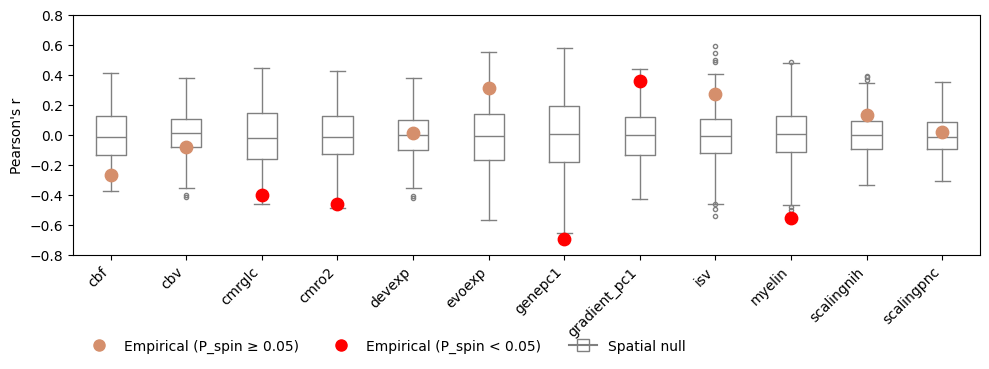

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# decide significance using p_spin or sig_fdr if you prefer FDR
alpha = 0.05
vr_df["sig"] = vr_df["p_spin"] < alpha

# order however you want them to appear on x axis
vr_df = vr_df.sort_values("map").reset_index(drop=True)

# collect null arrays in that same order
null_arrays = [null_corrs[m] for m in vr_df["map"]]

xpos = np.arange(len(vr_df))

fig, ax = plt.subplots(figsize=(10,4))

# draw gray boxplots for null distributions
ax.boxplot(
    null_arrays,
    positions=xpos,
    widths=0.4,
    patch_artist=False,
    boxprops=dict(color='gray', linewidth=1),
    whiskerprops=dict(color='gray', linewidth=1),
    capprops=dict(color='gray', linewidth=1),
    medianprops=dict(color='gray', linewidth=1),
    flierprops=dict(
        marker='o',
        markerfacecolor='none',
        markeredgecolor='gray',
        markersize=3,
        linestyle='none'
    ),
)

# overlay empirical r values as dots
for xi, row in vr_df.iterrows():
    ax.scatter(
        xi,
        row["r"],
        s=80,
        color=('red' if row["sig"] else '#d58f6c'),
        zorder=3,
    )

ax.set_ylabel("Pearson's r")
ax.set_xticks(xpos)
ax.set_xticklabels(vr_df["map"], rotation=45, ha='right')
ax.set_ylim(-0.8, 0.8)

emp_ns = mlines.Line2D([], [], color='#d58f6c', marker='o', linestyle='None', markersize=8,
                       label="Empirical (P_spin ≥ 0.05)")
emp_sig = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8,
                        label="Empirical (P_spin < 0.05)")
null_leg = mlines.Line2D([], [], color='gray', marker='s', fillstyle='none', linestyle='-', markersize=8,
                         label="Spatial null")

ax.legend(handles=[emp_ns, emp_sig, null_leg],
          loc='upper left',
          bbox_to_anchor=(0, -0.3),
          ncol=3,
          frameon=False)

plt.tight_layout()
fig.savefig("vr_boxplots.png", dpi=150, bbox_inches="tight")
plt.show()
